<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

Text(0, 0.5, 'y (экспериментальные измерения)')

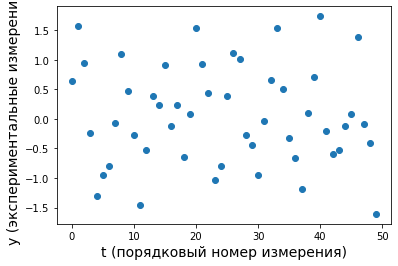

In [3]:
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = np.sin(t[i]) + noise[i]

    return t, y

data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

plt.plot(t, y, 'o') 
plt.xlabel('t (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (экспериментальные измерения)', fontsize=14)

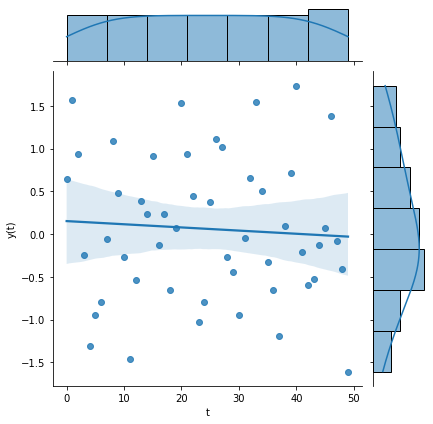

In [ ]:
# создаем датафрейм для красивого изображения данных 
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

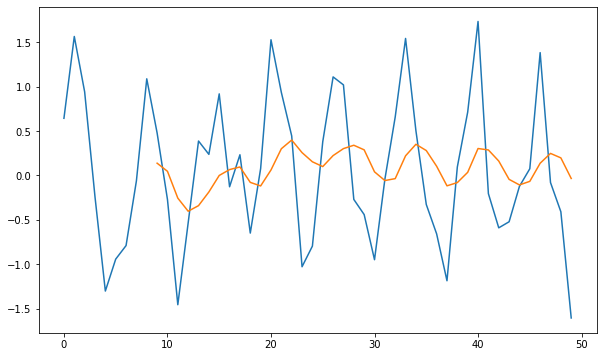

In [ ]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = 10).mean().plot()
y_mean = df['y(t)'].rolling(window = 10).mean()

         t         y
0      0.0  0.470858
1      1.0  0.143182
2      2.0  0.569440
3      3.0  0.326372
4      4.0 -1.264977
...    ...       ...
1495  45.0  1.063230
1496  46.0  0.273412
1497  47.0  0.494722
1498  48.0 -1.912562
1499  49.0 -0.709930

[1500 rows x 2 columns]


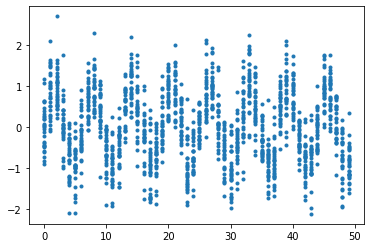

In [ ]:
data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

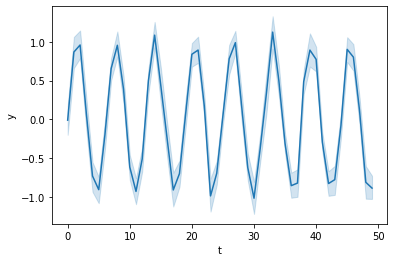

In [ ]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

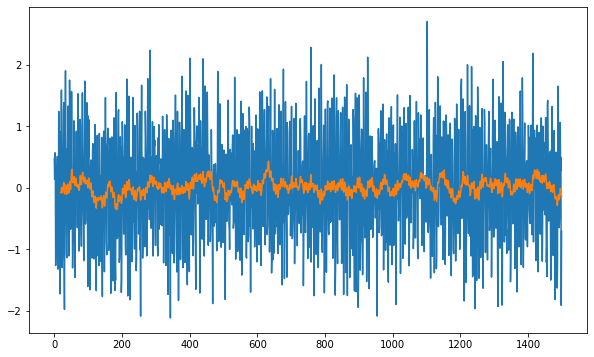

In [ ]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

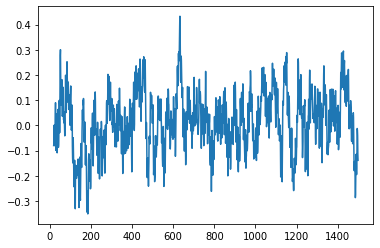

In [ ]:
plt.plot(y_mean)

# **Пример обработки файла с историческими данными о курсе доллара к рублю**

In [35]:
# загрузить курс доллара
data_usdrub = pd.read_csv("UsdRubTime.csv", sep = ';')
         
df_usdrub = pd.DataFrame(data_usdrub, columns = ['Close', 'Week'])

print(df_usdrub.head)
y = df_usdrub['Close']
T = max(df_usdrub['Week'])
N = len(df_usdrub['Week'])
t = np.linspace(1, T, N)

print(N, T)

<bound method NDFrame.head of        Close  Week
0      0.988     1
1      0.993     2
2      1.000     3
3      1.020     4
4      1.300     5
...      ...   ...
1537  73.348  1538
1538  74.230  1539
1539  76.135  1540
1540  75.712  1541
1541  76.072  1542

[1542 rows x 2 columns]>
1542 1542


In [24]:
df_usdrub = df_usdrub[df_usdrub.Week > 350]

print(df_usdrub.head)

<bound method NDFrame.head of        Close  Week
350   28.256   351
351   28.316   352
352   28.261   353
353   28.376   354
354   28.366   355
...      ...   ...
1537  73.348  1538
1538  74.230  1539
1539  76.135  1540
1540  75.712  1541
1541  76.072  1542

[1192 rows x 2 columns]>


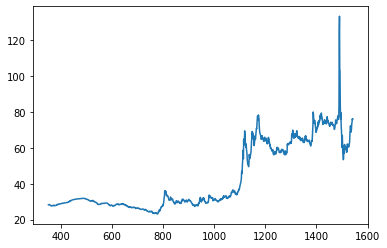

In [25]:
plt.plot(df_usdrub['Week'],df_usdrub['Close'])

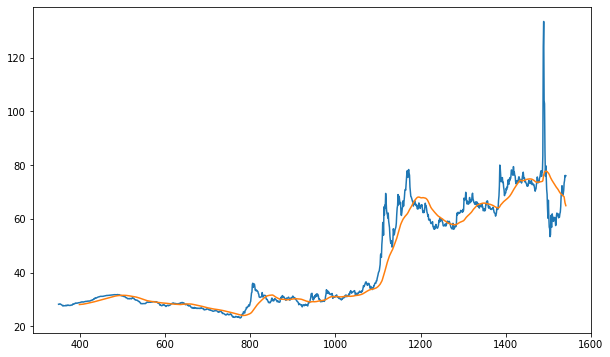

In [26]:
# расчет скользящего среднего
df_usdrub['Close'].plot(figsize=(10,6))
df_usdrub['Close'].rolling(window = 50).mean().plot()
y_usdrub_mean = df_usdrub['Close'].rolling(window = 50).mean()

In [38]:
y_usdrub_mean = y_usdrub_mean[~np.isnan(y_usdrub_mean)]
print(y_usdrub_mean.head)

<bound method NDFrame.head of 399     28.15276
400     28.16446
401     28.17720
402     28.19120
403     28.20518
          ...   
1537    68.16578
1538    67.16870
1539    66.02306
1540    65.45688
1541    64.92286
Name: Close, Length: 1143, dtype: float64>


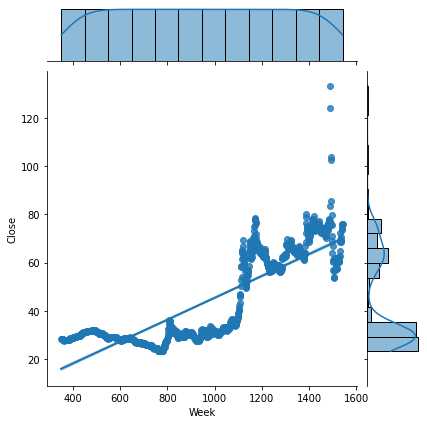

In [27]:
seaborn.jointplot(data=df_usdrub, x = "Week", y = "Close",kind='reg')

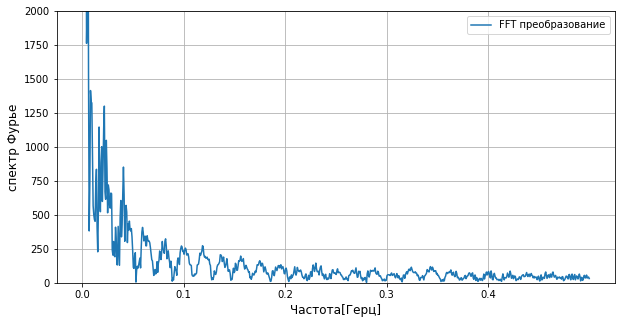

In [42]:
from scipy.fft import fft, fftfreq

yf = fft(y.values)
#yf = fft(y_usdrub_mean.values)
xf = fftfreq(N, T/N)[:N//2]
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(yf[0:N//2]),label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
plt.xticks(np.arange(0, np.max(xf), 0.1))
plt.ylim(0,2000)
plt.grid()
plt.legend()
plt.show()